# Análisis predictivo: Clustering y clasificación

## Introducción

La siguiente etapa del proyecto consiste en realizar una serie de agrupaciones usando algoritmos no supervisados del Machine Learning, para posteriormente hacer un análisis de clasificación usando indicadores externos. El objetivo de este análisis es identificar patrones entre el desempeño olímpico de los países y factores externos tanto geográficos como socioeconómicos.

El análisis, tal y como se ha manejado hasta el momento, se realizará tomando en cuenta las ediciones de los JJ.OO. de Verano e Invierno por separado. Para cada edición se realizarán dos agrupaciones, una para el número de participaciones y otra para la cantidad de medallas de oro plata y bronce obtenidas en senda edición. En total el análisis constará de 4 tipos de agrupaciones distintas.

### Objetivos del análisis
 1. Identificar patrones entre las diferentes clasificaciones y la posición geográfica, el continente y la región que se le asigna.
 2. Examinar si existen similitudes entre países en el mismo cluster o clase usando como punto de comparación algunos indicadores socioeconómicos. 

## Descripción de los datos

Los datasets que serán usados para este estudio serán [olympics.csv](data/olympics.csv) y [info_countries.csv](data/info_countries.csv), que están alojados en el directorio `data/`. Estos datasets contienen información del total de medallas ganadas y los promedios de los indicadores de interés de cada país, respectivamente. Estos datasets se han extraído de diversas fuentes, y los detalles de este proceso están descritos en el notebook numerado con [00](00-Tratamiento_de_Datos.ipynb).

Los datasets mencionados ya han sido usados anteriormente en el [análisis descriptivo](01-Analisis_estadistico_descriptivo.ipynb) que se ha realizado anteriormente; en el notebook correspondiente encontrará detalles del análisis descriptivo y de correlación. Para evitar repetirme, los detalles de los datasets no se incluirán en este notebook. Si el lector desea conocer más puede recurrir al notebook [01-Analisis_estadistico_descriptivo.ipynb](01-Analisis_estadistico_descriptivo.ipynb).

## Preparando el ambiente

### Imports

Los módulos que se usará en este análisis serán los siguientes,

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans

Y el proyecto fue desarrollado usando **Python 3.8.10**. Para más información de los requerimientos de los módulos puede revisar el archivo [requirements.txt](requirements.txt).

Por otra parte, vamos a fija la seed para que el estado aleatorio siempre sea el mismo.

In [93]:
np.random.seed(42)

### Dataframe

La herramienta principal que se usarán serán los dataframes ofrecidos por el módulo Pandas. Los datasets se importarán como dataframes y así se podrá trabajar de manera más cómoda con los datos. Sin embargo, a diferencia del análisis descriptivo hecho anteriormente, en este caso ambos datasets serán alojados en el mismo dataframe desde un inicio.

In [94]:
def importar_dataframe():
	df_medallas = pd.read_csv("data/olympics.csv")
	df_medallas = df_medallas.dropna(subset="ISO_code")
	df_countries = pd.read_csv("data/info_countries.csv")

	return df_medallas.merge(df_countries, how="inner", on="ISO_code")

df = importar_dataframe()
df.head()

,Country,Country_name,Country_code_coi,ISO_code,Continente_x,Num_Summer,gold_summer,silver_summer,bronze_summer,Total_summer,...,Food_insecurity_media,GDP_per_capita_growth_media,GDP_per_capita_media,Health_expenditure_per_capita_media,Prevalence_of_undernourishment_media,Primary_completion_rate_media,Research_dev_expenditure_media,Vulnerable_employment_media,population_media,surface_area_media
0,Afghanistan (AFG),Afghanistan,AFG,AFG,Asia,16,0,0,2,2,...,19.328571,1.152146,416.667609,49.495439,27.938095,45.264939,NaN,88.861321,1.878244e+07,6.528600e+05
1,Albania (ALB),Albania,ALB,ALB,Europa,10,0,0,2,2,...,9.357143,2.946025,2704.306845,238.629357,5.666667,103.522464,0.120845,58.076484,2.713609e+06,2.875000e+04
2,Algeria (ALG),Algeria,ALG,DZA,África,15,7,4,9,20,...,9.300000,1.312632,2428.841080,201.586538,4.461905,83.105215,0.259473,29.516741,2.622281e+07,2.381740e+06
3,Argentina (ARG),Argentina,ARG,ARG,América,26,22,27,31,80,...,11.028571,0.995601,7948.212149,899.976744,3.395238,96.703933,0.495866,22.096759,3.320280e+07,2.780400e+06
4,Armenia (ARM),Armenia,ARM,ARM,Europa,8,2,11,9,22,...,0.620000,4.450079,2545.232810,281.954545,7.395238,96.017295,0.233435,65.218353,2.927306e+06,2.974000e+04


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 0 to 141
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               142 non-null    object 
 1   Country_name                          142 non-null    object 
 2   Country_code_coi                      142 non-null    object 
 3   ISO_code                              142 non-null    object 
 4   Continente_x                          142 non-null    object 
 5   Num_Summer                            142 non-null    int64  
 6   gold_summer                           142 non-null    int64  
 7   silver_summer                         142 non-null    int64  
 8   bronze_summer                         142 non-null    int64  
 9   Total_summer                          142 non-null    int64  
 10  Num_Winter                            142 non-null    int64  
 11  gold_winter        

El dataframe, llamado simplemente como `df`, cuenta con 142 registros, los cuales son los más esenciales para el análisis que realizaremos.

### Columnas e indicadores

A modo de agilizar y simplificar el código, también vamos a definir una serie de variables y listas que nos ayudarán más adelante a elegir los grupos de columnas de interés que usaremos en los análisis posteriores. Primero vamos a definir las correspondientes a los JJ.OO. de Verano,

In [96]:
# Numero de participaciones en los JJ.OO. de Verano
num_summer = ["Num_Summer"]

# Numero de medallas ganadas en los tres metales
medals_summer = ["gold_summer", "silver_summer", "bronze_summer"]

y luego las columnas correspondientes a los JJ.OO. de Invierno,

In [97]:
num_winter = ["Num_Winter"]
medals_winter = ["gold_winter", "silver_winter", "bronze_winter"]

Luego, definamos la lista de indicadores a utilizar. Los indicadores que usaremos aquí se ha seleccionado usando de base el análisis de correlación realizado en el Análisis Estadístico descriptivo. Solo se seleccionaron aquellos que obtuvieron una Correlación Débil o mayor en alguno de los parámetros olímpicos,

In [98]:
indicadores_summer = [
	"latitude",
	"AFFVA_media",
	"Access_to_electricity_media",
	"Cause_of_death_by_media",
	"Control_of_Corruption_media",
	"GDP_per_capita_media",
	"Health_expenditure_per_capita_media",
	"Prevalence_of_undernourishment_media",
	"Primary_completion_rate_media",
	"Research_dev_expenditure_media",
	"Vulnerable_employment_media",
	"population_media",
	"surface_area_media"
]

indicadores_winter = {
	"latitude",
	"AFFVA_media",
	"Access_to_electricity_media",
	"Cause_of_death_by_media",
	"Control_of_Corruption_media",
	"Expenditure_on_education_media",
	"GDP_per_capita_media",
	"Health_expenditure_per_capita_media",
	"Prevalence_of_undernourishment_media",
	"Primary_completion_rate_media",
	"Research_dev_expenditure_media",
	"Vulnerable_employment_media",
	"surface_area_media"
}

Como se puede notar, se usarán diferentes indicadores para cada edición de los JJ.OO. ya sea de Verano o Invierno.

In [99]:
datos_pais = ["nombre", "ISO_code", "Short_Name"]

## Clustering

Ahora comenzaremos con la clasificación de los datos. Esto lo realizaremos, como ya habíamos mencionado, separando ambas ediciones de los JJ.OO., y en cada uno se realizarán dos diferentes clasificaciones: una para el número de participaciones y otra para las medallas ganadas. Todas las clasificaciones se realizarán usando el algoritmo de KMeans, por lo que es necesario usar un criterio adecuado para determinar el número de clusters a realizar.

In [100]:
def metodo_del_codo(data, columns, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    X = data[columns]

    # Calcular inertia para diferentes números de clusters
    inertia = []
    for k in range(1, 15):
        kmeans = KMeans(n_clusters=k, n_init="auto")
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Graficar la inertia
    ax.plot(range(1, 15), inertia, marker='o')
    ax.set_xlabel('Número de Clusters')
    ax.set_ylabel('Inertia')
    ax.set_title('Método del Codo', fontdict={"fontsize" : 16})
    plt.show()


La función anterior nos ayudará a graficar las inercias para diferentes cantidades de clusters, y así poder aplicar el Método del Codo para determinar el número óptico de clusters a utilizar en cada caso. También usaremos otra función más para visualizar los datos una vez hayan sido "clusterizados". Para construir esta función usaremos `pairplot` de Seaborn,

In [101]:
def graficar_clusters(data, columnas, clusters_columna, palette="pastel"):
	sns.pairplot(data=data[columnas + [clusters_columna]], hue=clusters_columna, corner=True, palette=palette)
	plt.show()

Y con las herramientas bien definas, ya estamos listos para realizar clustering a los datos. 

### JJ.OO. de Verano

Comencemos con el clustering de los parámetros de los JJ.OO. de Verano. Comencemos con la columna de número de participaciones en esta edición. A pesar de que KMeans no se suele utilizar cuando $X$ es de una sola dimensión, se ha decidido que es lo que usará en esta ocasión. Vamos a aplicar el Método del Codo,

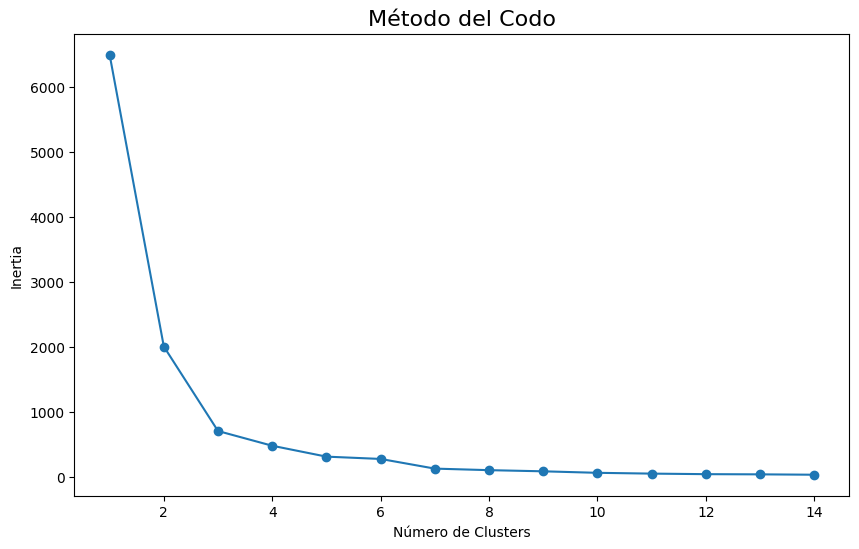

In [102]:
metodo_del_codo(data=df, columns=num_summer)

El cambio más abrupto que se puede observar es para 3 clústers, por lo que es el número que se usará. Procedamos el clustering,

In [103]:
kmeans_num_summer = KMeans(n_clusters=3, n_init="auto").fit(df[num_summer])
df["clusters_num_summer"] = kmeans_num_summer.labels_

Ordenamos las etiquetas de los clusters de menor a mayor dado el número de participaciones, 

In [104]:
mean_values = df.groupby(by="clusters_num_summer")[num_summer[0]].mean().sort_values()
df["clusters_num_summer"] = df["clusters_num_summer"].map(
	{old : new for new,old in enumerate(mean_values.index)}
)

Y procedamos con la visualización de los mismos. Como en este caso se "cluesterizó" con una sola columna, se usará `swarmplot` en lugar de la función hecha anteriormente,

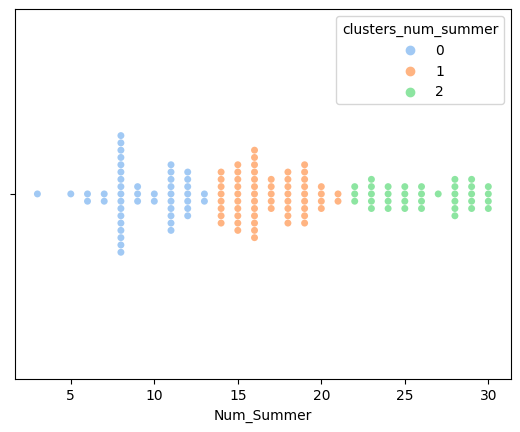

In [105]:
sns.swarmplot(df, x=num_summer[0], hue="clusters_num_summer", palette="pastel")
plt.show()

Ahora "clustericemos" el dataframe dadas las medallas ganadas en los tres metales. Antes que nada, echemos un vistazo a la distribución de los datos con un pairplot,

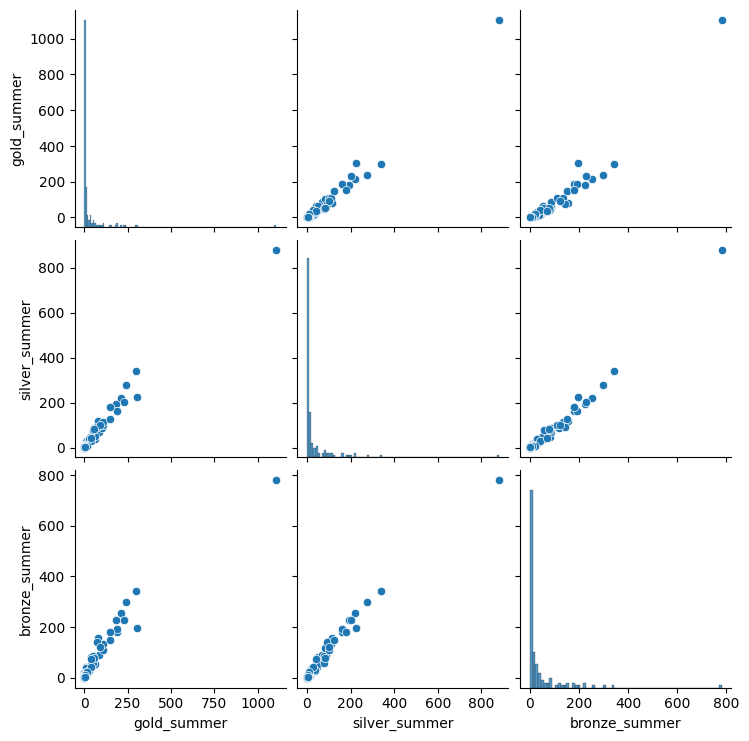

In [106]:
sns.pairplot(data=df[medals_summer])
plt.show()

Por lo que podemos observar, tenemos un valor muy extremo para las tres medallas. Como ya se había encontrado, este valor extremo corresponde a los datos de las medallas ganadas por USA, que tiene una clara ventaja respecto a todos los demás países,

In [107]:
usa = df.query("ISO_code == 'USA'")
usa[datos_pais + medals_summer]

,nombre,ISO_code,Short_Name,gold_summer,silver_summer,bronze_summer
134,Estados Unidos,USA,United States,1105,879,780


Sin embargo, para evitar ruido, necesitamos eliminarlo para realizar el kmeans de forma optima. El dato será devuelto después para realizar el estudio para las JJ.OO. de Invierno.

In [108]:
df = df.query("ISO_code != 'USA'")

Una vez hecho lo anterior, vamos a aplicar el Método del Codo,

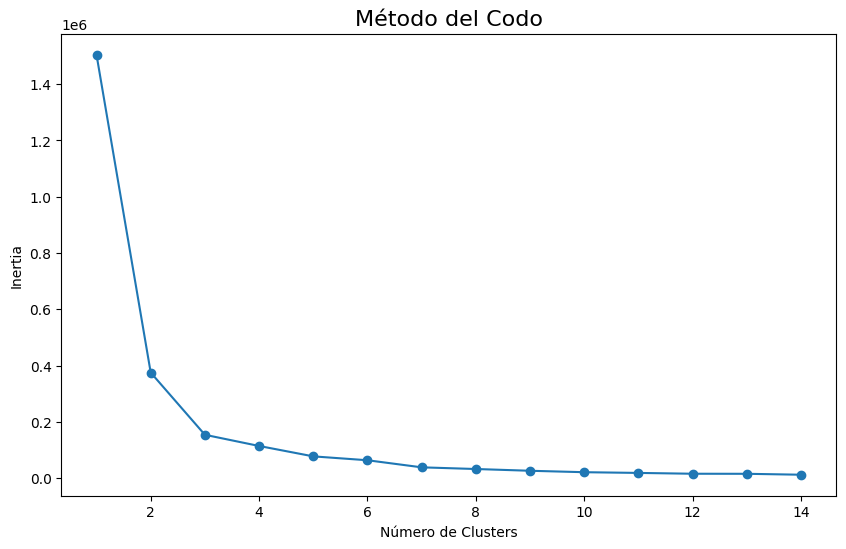

In [109]:
metodo_del_codo(data=df, columns=medals_summer)

Nuevamente usaremos 3 clústers para esta clasificación,

In [110]:
kmeans_medals_summer = KMeans(n_clusters=3, n_init="auto").fit(df[medals_summer])
df["clusters_medals_summer"] = kmeans_medals_summer.labels_

Ordenamos los clúster dada la distancia euclideana entre las tres medallas,

In [111]:
euclidean_distance = df.groupby(by="clusters_medals_summer")[medals_summer].apply(lambda x: np.linalg.norm(x.mean())).sort_values()
df["clusters_medals_summer"] = df["clusters_medals_summer"].map(
	{old : int(new) for new,old in enumerate(euclidean_distance.index)}
)

Y visualizamos los clústers obtenidos,

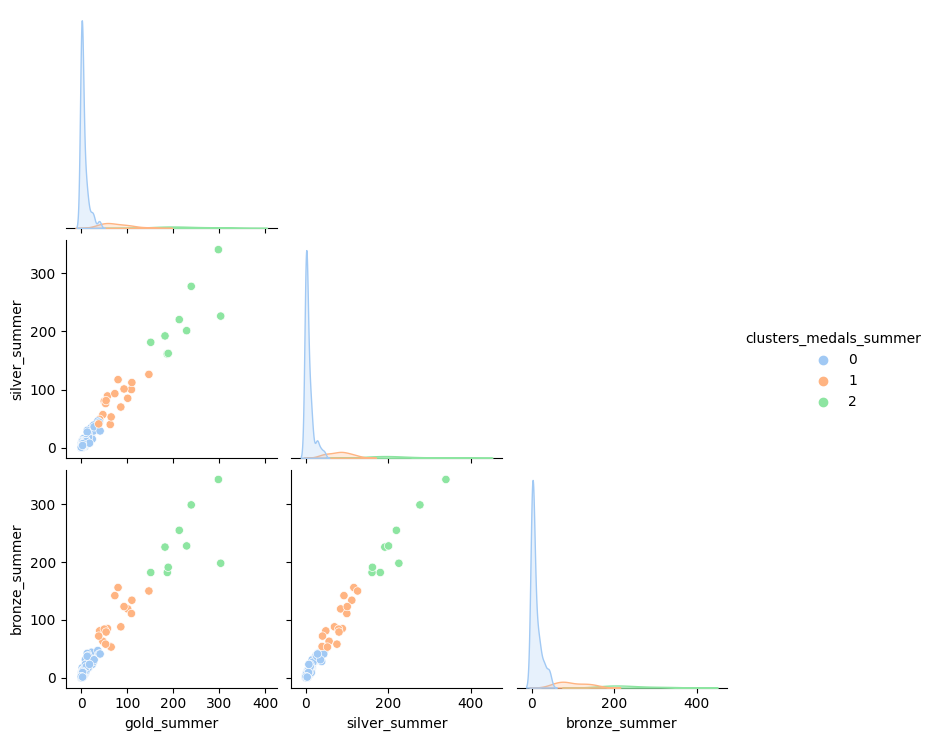

In [112]:
graficar_clusters(data=df, columnas=medals_summer, clusters_columna="clusters_medals_summer")

Como podemos observar, los clústers dividen los datos en zonas con claras diferencias de densidad. Esto es lo que se busca para un análisis posterior óptimo.

### JJ.OO. de Invierno

Es turno de hacer los clústers para los parámetros de los JJ.OO. de Invierno. El proceso es el mismo que en el anterior, por lo que nos iremos más rápido. Aunque antes de eso, no olvidemos volver a agregar a USA a los datos. 

In [113]:
df = pd.concat([df, usa], ignore_index=True)
df = df.sort_values(by="ISO_code").reset_index(drop=True)

Comencemos con el Método del Codo para el número de participaciones,

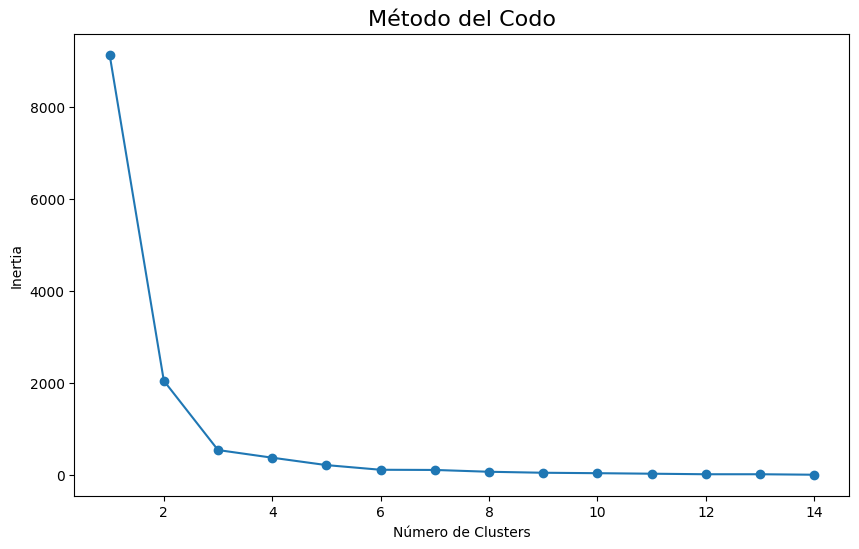

In [114]:
metodo_del_codo(data=df, columns=num_winter)

Nuevamente tendremos 3 clústers en este caso. Continuamos con KMeans,

In [115]:
kmeans_num_winter = KMeans(n_clusters=3, n_init="auto").fit(df[num_winter])
df["clusters_num_winter"] = kmeans_num_winter.labels_

Ordenamos los cústers,

In [116]:
mean_values = df.groupby(by="clusters_num_winter")[num_winter[0]].mean().sort_values()
df["clusters_num_winter"] = df["clusters_num_winter"].map(
	{old : new for new,old in enumerate(mean_values.index)}
)

Y visualizamos 

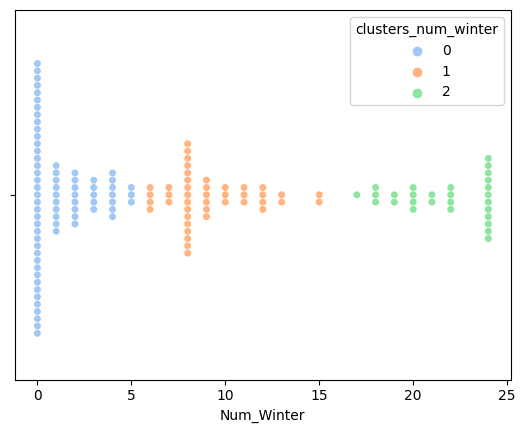

In [117]:
sns.swarmplot(df, x=num_winter[0], hue="clusters_num_winter", palette="pastel")
plt.show()

Ahora es turno de la cantidad de medallas ganadas por metal. Comenzamos por el Método del Codo,

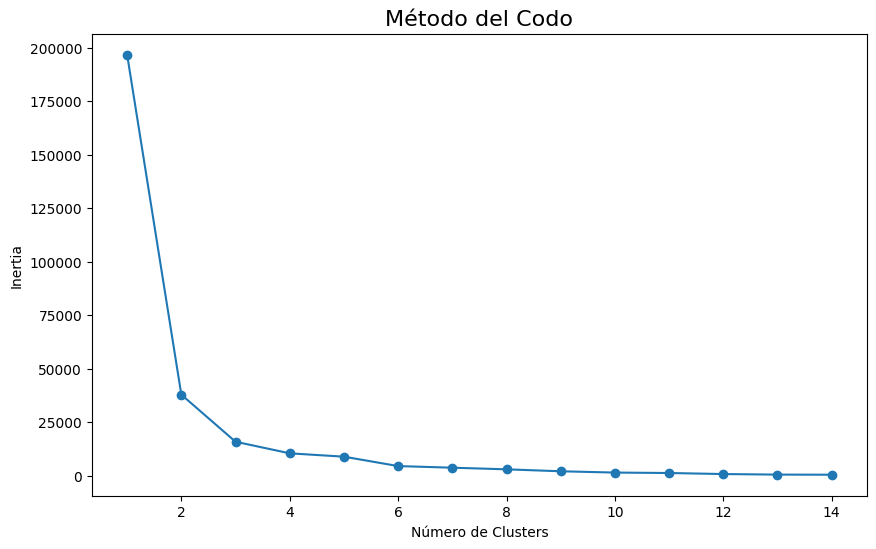

In [118]:
metodo_del_codo(data=df, columns=medals_winter)

En este caso parece que el número de clústers sera 2. Creamos los clústers, 

In [119]:
kmeans_medals_winter = KMeans(n_clusters=2, n_init="auto").fit(df[medals_winter])
df["clusters_medals_winter"] = kmeans_medals_winter.labels_

ordenamos,

In [120]:
euclidean_distance = df.groupby(by="clusters_medals_winter")[medals_winter].apply(lambda x: np.linalg.norm(x.mean())).sort_values()
df["clusters_medals_winter"] = df["clusters_medals_winter"].map(
	{old : int(new) for new,old in enumerate(euclidean_distance.index)}
)

y visualizamos

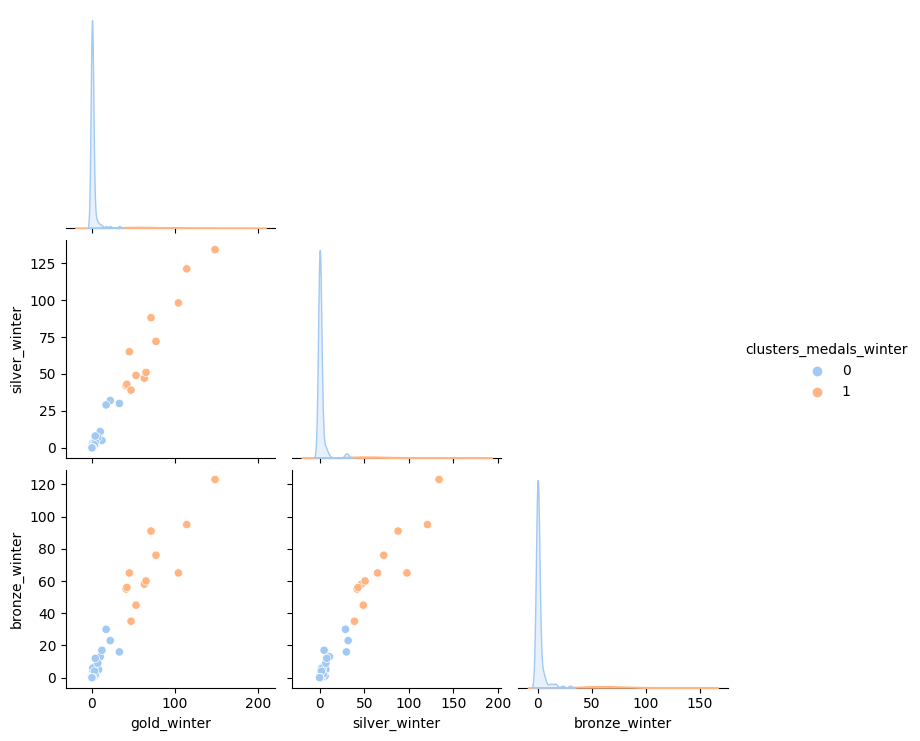

In [121]:
graficar_clusters(data=df, columnas=medals_winter, clusters_columna="clusters_medals_winter")

### Categorías

Ahora contamos con 4 nuevas columnas categóricas en `df`, cada una de ellas con un propósito. Creemos una lista con los nombres de estas columnas,

In [122]:
categorias = [
	"clusters_num_summer", "clusters_medals_summer",
	"clusters_num_winter", "clusters_medals_winter"
]

Bien, pues de aquí en adelante simplificaremos el trabajo. En lugar de llamar a cada columna categórica po su nombre, se les identificará como categorías 0, 1, 2 y 3, respectivamente. Esto concuerda con el índice de la lista que ocupan. De esta manera será más sencillo realizar el proceso de análisis sin abrumar con tantos nombres distintos.

Por supuesto, cuando llegue el momento de interpretar se regresarán a los nombres correctos.

## Visualización: Categorías en mapas

Antes de iniciar con la creación de modelos de clasificación con factores externos, visualicemos las clases en un mapamundi. Esta sección no es indispensable para el seguimiento del análisis, por lo que se puede omitir. 

Para realizar poder realizar la visualización en un mapamundi es necesario importar el siguiente módulo,

In [123]:
import geopandas as gpd

Geopandas es un módulo dedicado a trabajar con datos geoespaciales. Se extiende de Pandas, por lo que permite operar con nuestro dataframe. Antes de comenzar, importemos el dataframe con los datos geométricos para dibujar el mapamundi,

In [124]:
world = gpd.read_file("data/mapamundi")

La data del mapamundi importado se aloja en una serie de archivos en el directorio `data/mapamundi`.

El objetivo de la visualización es colorear cada país de un determinado color dependiendo la clase a la que pertenece. En `word` tenemos alojados los datos de cada país así como la construcción geométrica, y cada registro se puede identificar dado el código ISO 3016-1 Alpha 3. 

Ahora crearemos una función para crear las gráficas:

In [125]:
def crear_mapamundi(data, categoria, world, title="", group_labels=None,
						legend=False, palette="Blues", figsize=(11, 9)):

	world_cat = world.merge(
		data, how="left", left_on="iso_a3", right_on="ISO_code"
	)
	fig, ax = plt.subplots(figsize=figsize)

	world_cat.boundary.plot(ax=ax, linewidth=1)
	world_cat.plot(column=categoria, ax=ax, legend=legend,
				legend_kwds={'labels': group_labels + ["Missing values"]},
				categorical=True, cmap=palette,
				missing_kwds={
					"color": "lightgrey",
					"edgecolor": "red",
					"hatch": "///"
    			}
				)
	ax.set_title(title)
	ax.set_xticks([])
	ax.set_yticks([])
	plt.show()

### Categoría 0: Número total de participantes en los JJ.OO. de Verano.

Recordemos que los grupos para esta categoría, que corresponden a la columna `clusters_num_summer`, son 0, 1 y 2. Estos está ordenados de menor a mayor de la siguiente forma, donde muestra el mínimo y el máximo de participaciones dentro del grupo,

In [126]:
df.groupby(by=categorias[0]).apply(
	lambda group: pd.Series(
		[group[num_summer[0]].apply(e) for e in ["min", "max"]]
	)
).rename(
	index={i : f"Grupo {i}" for i in range(3)},
	columns={0 : "min", 1 : "max"}
)

,min,max
clusters_num_summer,,
Grupo 0,3,13
Grupo 1,14,21
Grupo 2,22,30


Y podemos visualizarlas en el siguiente mapa,

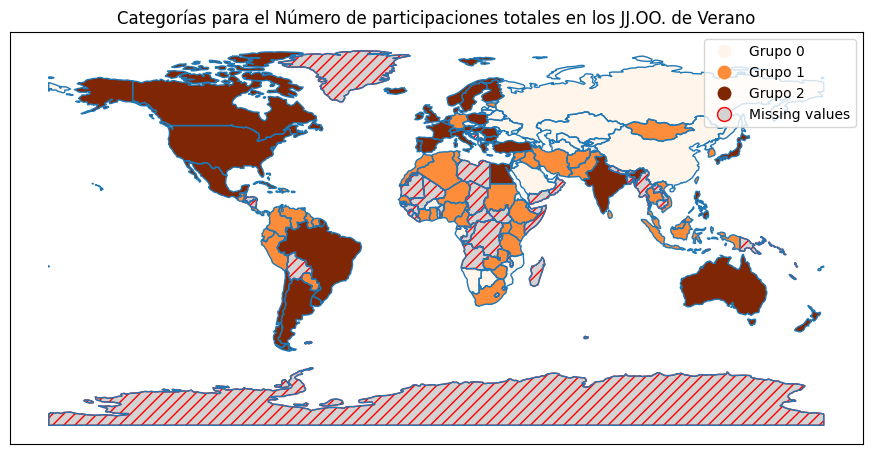

In [127]:
crear_mapamundi(df, categorias[0], world,
				title="Categorías para el Número de participaciones " +
					  "totales en los JJ.OO. de Verano",
				group_labels=[f"Grupo {i}" for i in range(3)],
				legend=True,
				palette="Oranges",
				)

### Categoría 1: Cantidad de medallas ganadas en los JJ.OO. de Verano.
Está categoría se refiere al número de medallas de oro, plata y bronce que han ganado cada país, y está contenida en la columna `clusters_medals_summer`. El ordenamiento en este caso es bastante más complejo. Se basa en *la distancia entre los centroides de cada grupo, con el origen del espacio de configuraciones* formado por la cantidad de medallas de oro, plata y bronce ganadas.

Para no complicarnos demasiado, nos basaremos en términos de rendimiento, donde el criterio que se usó es el presentado en el párrafo anterior. Vamos a resumirlo en la siguiente tabla,

| Grupo | Rendimiento | 
|-------|-------------|
|   0   |    Bajo     |
|   1   |  Moderado   | 
|   2   |    Alto     | 

Comprendido lo anterior, avancemos con la visualización del mapamundi,

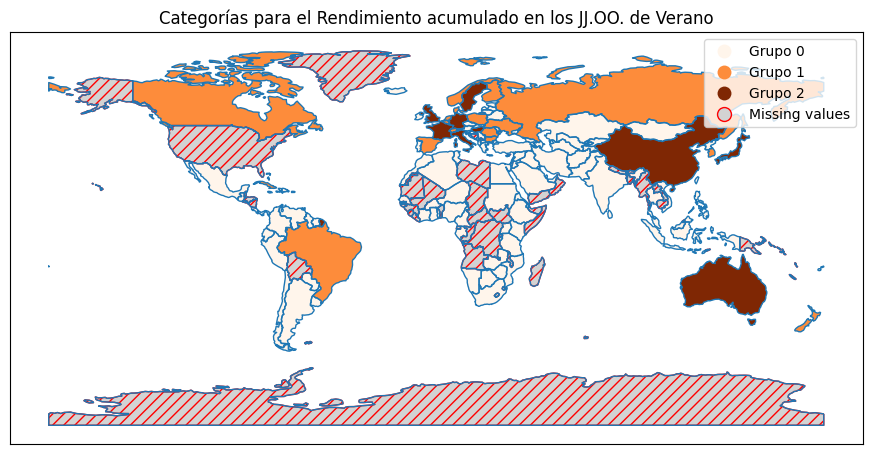

In [128]:
crear_mapamundi(df, categorias[1], world,
				title="Categorías para el Rendimiento acumulado " +
					  "en los JJ.OO. de Verano",
				group_labels=[f"Grupo {i}" for i in range(3)],
				legend=True,
				palette="Oranges",
				)

Cabe destacar que para esta categoría *USA no fue incluida dado que sus resultados mostraban resultados extremos*. En todo caso su rendimiento podría calificarse como *Sobresaliente*.

### Categoría 2: Número total de participantes en los JJ.OO. de Invierno.

Para esta categoría también tenemos tres grupos, numerados también como 0, 1 y 2. La columna correspondiente se llama `clusters_num_winter`. El ordenamiento también sigue la lógica anterior, clasificando los datos de mayor a menor. La siguiente tabla muestra los máximos y mínimos de cada grupo,

In [129]:
df.groupby(by=categorias[2]).apply(
	lambda group: pd.Series(
		[group[num_winter[0]].apply(e) for e in ["min", "max"]]
	)
).rename(
	index={i : f"Grupo {i}" for i in range(3)},
	columns={0 : "min", 1 : "max"}
)

,min,max
clusters_num_winter,,
Grupo 0,0,5
Grupo 1,6,15
Grupo 2,17,24


Entendido lo anterior, vamos con el mapamundi,

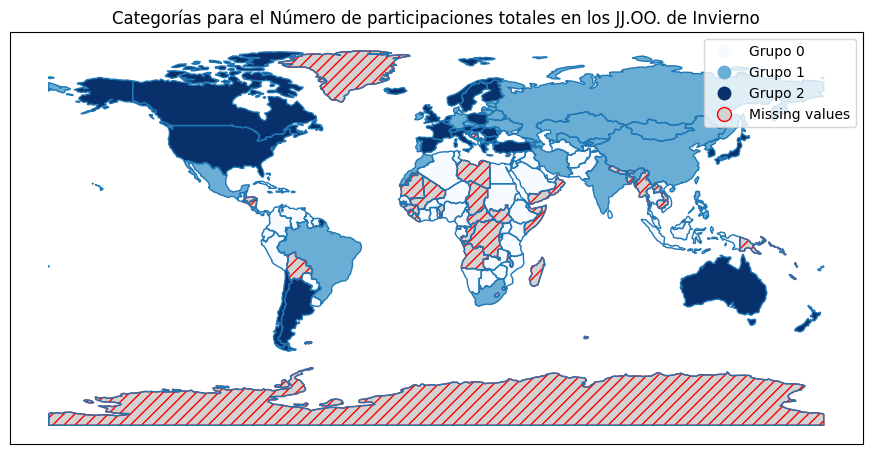

In [130]:
crear_mapamundi(df, categorias[2], world,
				title="Categorías para el Número de participaciones " +
					  "totales en los JJ.OO. de Invierno",
				group_labels=[f"Grupo {i}" for i in range(3)],
				legend=True,
				palette="Blues",
				)

### Categoría 3: Cantidad de medallas ganadas en los JJ.OO. de Invierno

Para esta categoría, a diferencia de las anteriores, los grupos generados son 2; 0 y 1. La columna que contiene esta clasificación es `clusters_medals_winter`. Esta columna, al igual que la semejante para la edición de Verano de los JJ.OO., es a la que se ha denominado desempeño.

El ordenamiento sigue el mismo criterio: la *distancia del centroide de cada grupo con el origen del espacio de configuraciones*. Aunque siempre es mejor mantenerlo simple. Los grupos hay que entenderlos dada la siguiente tabla,

| Grupo | Rendimiento | 
|-------|-------------|
|   0   |    Bajo     | 
|   1   |    Alto     |

Y sin nada más que decir, miremos el mapamundi con la última categoría,

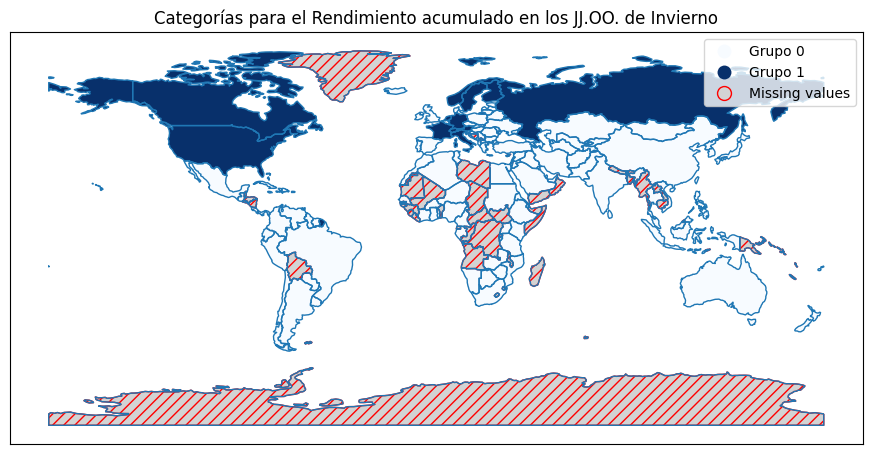

In [131]:
crear_mapamundi(df, categorias[3], world,
				title="Categorías para el Rendimiento acumulado " +
					  "en los JJ.OO. de Invierno",
				group_labels=[f"Grupo {i}" for i in range(2)],
				legend=True,
				palette="Blues",
				)